# Dependencies

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms as T
from torchvision import datasets, ops
from torchvision.models.feature_extraction import create_feature_extractor
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

# COCO dataset

In [4]:
# git clone https://github.com/lizhogn/tiny_coco_dataset.git

In [5]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush', 'empty'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], 
          [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100


revert_normalization = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225]
)


def plot_im_with_boxes(im, boxes, probs=None, ax=None):
    
    if ax is None:
        plt.imshow(im)
        ax = plt.gca()
        
    for i, b in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = b
        
        patch = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=COLORS[i], linewidth=2)
        
        ax.add_patch(patch)
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[i].item()
                text = f'{CLASSES[cl]}'
            else:
                cl = probs[i].argmax().item()
                text = f'{CLASSES[cl]}: {probs[i,cl]:0.2f}'
        else:
            text = ''
            
        ax.text(xmin, ymin, text, fontsize=7,
                bbox=dict(facecolor='yellow', alpha=0.5))
    
    
def preprocess_target(anno, im_w, im_h):
    
    anno = [obj for obj in anno 
            if 'iscrowd' not in obj or obj['iscrowd'] == 0]

    boxes = [obj["bbox"] for obj in anno]
    boxes = torch.as_tensor(
        boxes, dtype=torch.float32).reshape(-1, 4)
    
    # xywh -> xyxy
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=im_w)
    boxes[:, 1::2].clamp_(min=0, max=im_h)
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]

    classes = [obj["category_id"] for obj in anno]
    classes = torch.tensor(classes, dtype=torch.int64)
    classes = classes[keep]

    # scales boxes to [0,1]
    boxes[:, 0::2] /= im_w
    boxes[:, 1::2] /= im_h
    boxes.clamp_(min=0, max=1)

    boxes = ops.box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')
    return classes, boxes

class MyCocoDetection(datasets.CocoDetection):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge = 480

        self.T = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.485, .456, .406],
                        std=[.229, .224, .225]),
            T.Resize((self.edge, self.edge), antialias=True)
        ])

        self.T_target = preprocess_target

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        # PIL image
        w, h = img.size

        input_ = self.T(img)
        classes, boxes = self.T_target(target, w, h)

        return input_, (classes, boxes)

def collate_fn(inputs):
    input_ = torch.stack([i[0] for i in inputs])
    classes = tuple([i[1][0] for i in inputs])
    boxes = tuple([i[1][1] for i in inputs])
    return input_, (classes, boxes)

In [6]:
train_ds = MyCocoDetection(
    'tiny_coco_dataset/tiny_coco/train2017/',
    'tiny_coco_dataset/tiny_coco/annotations/instances_train2017.json',
)

train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f'\nNumber of training samples: {len(train_ds)}')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Number of training samples: 50


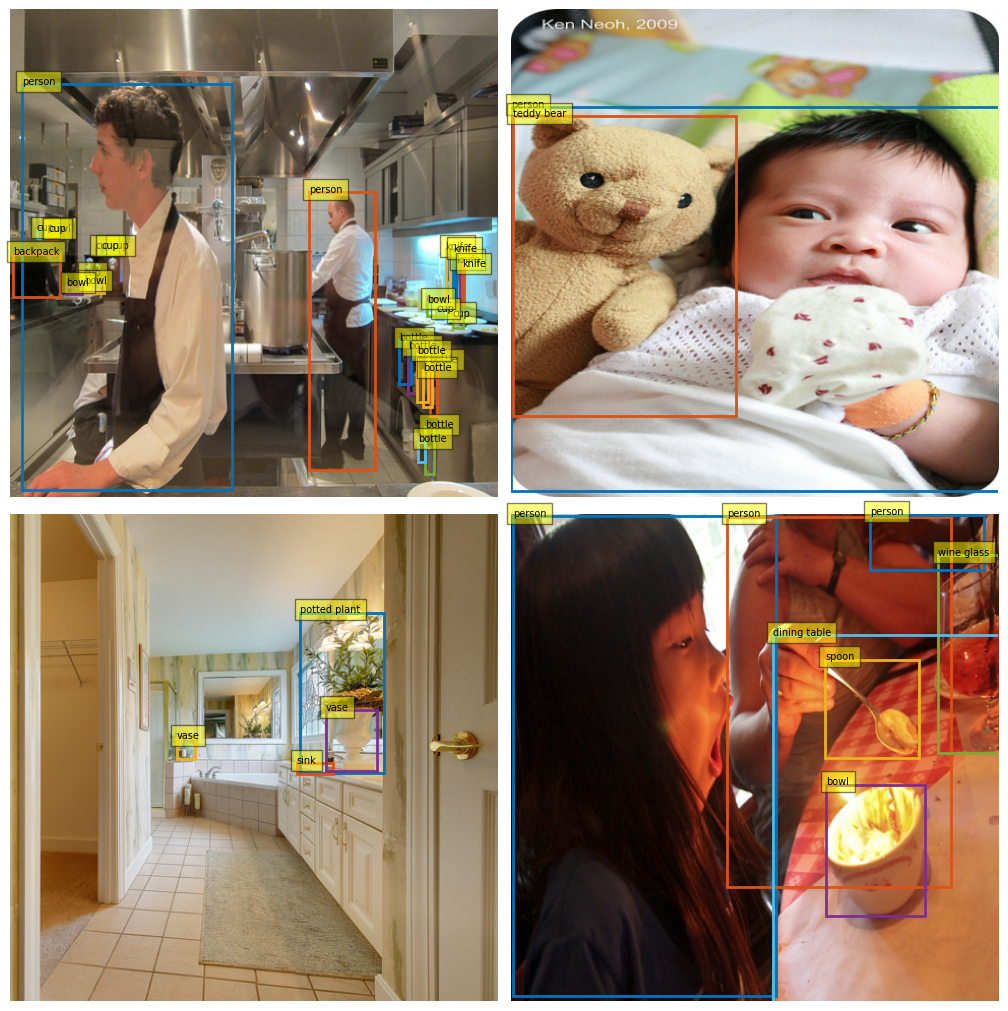

In [7]:

input_, (target) = next(iter(train_loader))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)

for ix in range(4):
    t_cl = target[0][ix].cuda()
    t_bbox = target[1][ix].cuda()

    t_bbox = ops.box_convert(
        t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].\
        permute(1,2,0).cpu().clip(0,1)

    ax = fig.add_subplot(2, 2, ix+1)
    ax.imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=ax)
    ax.set_axis_off()
    

In [8]:
# fig.savefig('coco_samples.jpg', dpi=300, bbox_inches='tight')
# !realpath coco_samples.jpg

# The DETR Architecture

## CNN Backbone

In [9]:

backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0',
                           'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
)

d_model = 256
conv1x1 = nn.Conv2d(2048, d_model, kernel_size=1, stride=1)

x = torch.randn((1, 3, 480, 480))
embeddings = backbone(x)['layer4']
embeddings = conv1x1(embeddings)

print(x.shape, embeddings.shape)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

torch.Size([1, 3, 480, 480]) torch.Size([1, 256, 15, 15])


## Transformer's encoder

In [10]:
embeddings_old = embeddings.clone()
embeddings = rearrange(embeddings, 'b c h w -> b (h w) c')

print(embeddings_old.shape, embeddings.shape)

torch.Size([1, 256, 15, 15]) torch.Size([1, 225, 256])


In [11]:
# the original implementation uses sine spatial PE
n_tokens = 225

inp_pe = nn.Parameter(
    torch.rand((1, n_tokens, d_model)),
    requires_grad=False)

embeddings += inp_pe

print(inp_pe.shape, embeddings.shape)

torch.Size([1, 225, 256]) torch.Size([1, 225, 256])


In [12]:
n_heads = 8
encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model)

n_layers = 6
transformer_encoder = nn.TransformerEncoder(
    encoder_layer, num_layers=n_layers)

out_encoder = transformer_encoder(embeddings)

print(out_encoder.shape)

torch.Size([1, 225, 256])


## Transformer's decoder

In [13]:
n_queries = 100

queries = nn.Parameter(
    torch.rand((1, n_queries, d_model)),
    requires_grad=False)

print(queries.shape, embeddings.shape)

torch.Size([1, 100, 256]) torch.Size([1, 225, 256])


In [14]:
decoder_layer = nn.TransformerDecoderLayer(
    d_model=d_model,
    nhead=n_heads,
    dim_feedforward=4*d_model,
    batch_first=True)

transformer_decoder = nn.TransformerDecoder(
    decoder_layer, num_layers=n_layers)

out_decoder = transformer_decoder(queries, out_encoder)

print(out_decoder.shape, queries.shape, out_encoder.shape)

torch.Size([1, 100, 256]) torch.Size([1, 100, 256]) torch.Size([1, 225, 256])


## FFN Heads

In [15]:
n_classes = 92

linear_class = nn.Linear(d_model, n_classes)
linear_bbox = nn.Linear(d_model, 4)

pred_classes = linear_class(out_decoder)
pred_bboxes = linear_bbox(out_decoder)

print(pred_classes.shape, pred_bboxes.shape)

torch.Size([1, 100, 92]) torch.Size([1, 100, 4])


## Putting it all together

In [16]:

def get_hook(outs, name):
    def hook(self, input, output):
        outs[name] = output
    return hook


class DETR(nn.Module):

    def __init__(
        self, d_model=256, n_classes=92, n_tokens=225,
        n_layers=6, n_heads=8, n_queries=100
    ):
        super().__init__()

        self.backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0',
                           'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
        )


        self.conv1x1 = nn.Conv2d(
            2048, d_model, kernel_size=1, stride=1)

        self.pe_encoder = nn.Parameter(
            torch.rand((1, n_tokens, d_model)),
            requires_grad=True)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model, dropout=0.1)
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers)

        self.queries = nn.Parameter(
            torch.rand((1, n_queries, d_model)),
            requires_grad=True)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model,
            batch_first=True, dropout=0.1)
        
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=n_layers)

        self.linear_class = nn.Linear(d_model, n_classes)
        self.linear_bbox = nn.Linear(d_model, 4)

        # Add hooks to get intermediate outcomes
        self.decoder_outs = {}    
        for i, L in enumerate(self.transformer_decoder.layers):
            name = f'layer_{i}'
            L.register_forward_hook(
                get_hook(self.decoder_outs, name))
        
    
    def forward(self, x):
        tokens = self.backbone(x)['layer4']
        tokens = self.conv1x1(tokens)
        tokens = rearrange(tokens, 'b c h w -> b (h w) c')

        out_encoder = self.transformer_encoder(
            tokens + self.pe_encoder)
        
        out_decoder = self.transformer_decoder(
            self.queries.repeat(len(out_encoder), 1, 1),
            out_encoder)

        # Compute outcomes for all intermediate
        # decoder's layers
        outs = {}
        for n, o in self.decoder_outs.items():
            outs[n] = {
                'cl': self.linear_class(o),
                'bbox': self.linear_bbox(o)
            }
        
        return outs

In [17]:
detr = DETR(
    d_model=256, n_classes=92, n_tokens=225, 
    n_layers=6, n_heads=8, n_queries=100
)

x = torch.randn((1, 3, 480, 480))
outs = detr(x)
pred_cl, pred_boxes = outs['layer_5'].values()

print(pred_cl.shape, pred_boxes.shape)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([1, 100, 92]) torch.Size([1, 100, 4])


# Training

## Set prediction problem

In [18]:

train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

input_, (tgt_cl, tgt_bbox) = next(iter(train_loader))

outs = detr(input_)
out_cl, out_bbox = outs['layer_5'].values()

train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

input_, (tgt_cl, tgt_bbox) = next(iter(train_loader))

outs = detr(input_)
out_cl, out_bbox = outs['layer_5'].values()

out_bbox = out_bbox.sigmoid()

o_bbox = out_bbox[0]
t_bbox = tgt_bbox[0]
o_cl = out_cl[0]
t_cl = tgt_cl[0]
    
o_probs = o_cl.softmax(dim=-1)

# Negative sign here because we want the maximum magnitude
C_classes = -o_probs[..., t_cl]

# Positive sign here because we want to shrink the l1-norm
C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

# Negative sign here because we want the maximum magnitude
C_giou = -ops.generalized_box_iou(
    ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)

C_total = 1*C_classes + 5*C_boxes + 2*C_giou

# Convert the tensor to numpy array
C_total = C_total.cpu().detach().numpy()

# Find the optimum pairs that produces the minimum summation.
# The method returns the pair indices
o_ixs, t_ixs = linear_sum_assignment(C_total)

print(t_bbox.shape, o_bbox.shape, C_total.shape)
out_bbox = out_bbox.sigmoid()

o_bbox = out_bbox[0]
t_bbox = tgt_bbox[0]
o_cl = out_cl[0]
t_cl = tgt_cl[0]
    
o_probs = o_cl.softmax(dim=-1)

# Negative sign here because we want the maximum magnitude
C_classes = -o_probs[..., t_cl]

# Positive sign here because we want to shrink the l1-norm
C_boxes = torch.cdist(o_bbox, t_bbox, p=1)

# Negative sign here because we want the maximum magnitude
C_giou = -ops.generalized_box_iou(
    ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)

C_total = 1*C_classes + 5*C_boxes + 2*C_giou

# Convert the tensor to numpy array
C_total = C_total.cpu().detach().numpy()

# Find the optimum pairs that produces the minimum summation.
# The method returns the pair indices
o_ixs, t_ixs = linear_sum_assignment(C_total)

print(t_bbox.shape, o_bbox.shape, C_total.shape)

torch.Size([26, 4]) torch.Size([100, 4]) (100, 26)
torch.Size([26, 4]) torch.Size([100, 4]) (100, 26)


## The loss function

In [19]:
# Transform indices to tensors
o_ixs = torch.IntTensor(o_ixs)
t_ixs = torch.IntTensor(t_ixs)

# Reorder o_ixs to naturally align with target_cl length, such
# the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
o_ixs = o_ixs[t_ixs.argsort()]

# Average over the number of boxes, not the number of coordinates
num_boxes = len(t_bbox)
loss_bbox = F.l1_loss(
    o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes

# Vectorize the operation
target_gIoU = ops.generalized_box_iou(
    ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
    ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
)
# Get only the matrix diagonal that contains the bipartite pairs
# and transform gIoU into a loss
loss_giou = 1 - torch.diag(target_gIoU).mean()

# Assign empty class for the outside predictions
queries_classes_label = torch.full(o_probs.shape[:1], 91)
queries_classes_label[o_ixs] = t_cl
loss_class = F.cross_entropy(o_cl, queries_classes_label)

loss_total = 1*loss_class + 5*loss_bbox + 2*loss_giou
print(loss_total)

tensor(6.7516, grad_fn=<AddBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Auxiliary losses

In [24]:

def get_hook(outs, name):
    def hook(self, input, output):
        outs[name] = output
    return hook


class DETR(nn.Module):

    def __init__(
        self, d_model=256, n_classes=92, n_tokens=225,
        n_layers=6, n_heads=8, n_queries=100
    ):
        super().__init__()

        self.backbone = create_feature_extractor(
            torch.hub.load('pytorch/vision:v0.10.0',
                           'resnet50', pretrained=True),
            return_nodes={'layer4': 'layer4'}
        )

        self.conv1x1 = nn.Conv2d(
            2048, d_model, kernel_size=1, stride=1)

        self.pe_encoder = nn.Parameter(
            torch.rand((1, n_tokens, d_model)),
            requires_grad=True)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model, dropout=0.1)
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=n_layers)

        self.queries = nn.Parameter(
            torch.rand((1, n_queries, d_model)),
            requires_grad=True)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=4*d_model,
            batch_first=True, dropout=0.1)
        
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer, num_layers=n_layers)

        self.linear_class = nn.Linear(d_model, n_classes)
        self.linear_bbox = nn.Linear(d_model, 4)

        # Add hooks to get intermediate outcomes
        self.decoder_outs = {}    
        for i, L in enumerate(self.transformer_decoder.layers):
            name = f'layer_{i}'
            L.register_forward_hook(
                get_hook(self.decoder_outs, name))
        
    
    def forward(self, x, suffix=None):
        torch.save(x, f'a.x.{suffix}.pt')
        tokens = self.backbone(x)['layer4']
        
        tokens = self.conv1x1(tokens)
        tokens = rearrange(tokens, 'b c h w -> b (h w) c')

        out_encoder = self.transformer_encoder(
            tokens + self.pe_encoder)
        
        out_decoder = self.transformer_decoder(
            self.queries.repeat(len(out_encoder), 1, 1),
            out_encoder)

        # Compute outcomes for all intermediate
        # decoder's layers
        outs = {}
        for n, o in self.decoder_outs.items():
            outs[n] = {
                'cl': self.linear_class(o),
                'bbox': self.linear_bbox(o)
            }
        
        return outs

## Putting it all together

In [25]:

def compute_sample_loss(
    o_bbox, t_bbox, o_cl, t_cl, n_queries=100):
    
    # If  the example has none box, we just feed it with empty classes.
    if len(t_cl) > 0:
        
        t_bbox = t_bbox.cuda()
        t_cl = t_cl.cuda()

        o_probs = o_cl.softmax(dim=-1)

        # Negative sign here because we want the maximum magnitude
        C_classes = -o_probs[..., t_cl]
        
        # Positive sign here because we want to shrink the l1-norm
        C_boxes = torch.cdist(o_bbox, t_bbox, p=1)
        
        # Negative sign here because we want the maximum magnitude
        C_giou = -ops.generalized_box_iou(
            ops.box_convert(o_bbox, in_fmt='cxcywh', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
        )
        
        C_total = 1*C_classes + 5*C_boxes + 2*C_giou
        
        # Convert the tensor to numpy array
        C_total = C_total.cpu().detach().numpy()
        
        # Find the optimum pairs that produces the minimum summation.
        # the method returns the pair indices
        o_ixs, t_ixs = linear_sum_assignment(C_total)            
        
        # Transform indices to tensors
        o_ixs = torch.IntTensor(o_ixs)
        t_ixs = torch.IntTensor(t_ixs)
        
        # Reorder o_ixs to naturally align with target_cl length, such
        # the pairs are {(o_ixs[0], t[0]), {o_ixs[1], t[1]}, ...}
        o_ixs = o_ixs[t_ixs.argsort()]
        
        # Average over the number of boxes, not the number of coordinates
        num_boxes = len(t_bbox)
        loss_bbox = F.l1_loss(
            o_bbox[o_ixs], t_bbox, reduce='sum') / num_boxes
        
        # vectorize the operation
        target_gIoU = ops.generalized_box_iou(
            ops.box_convert(o_bbox[o_ixs], in_fmt='cxcywh', out_fmt='xyxy'),
            ops.box_convert(t_bbox, in_fmt='cxcywh', out_fmt='xyxy')
        )
        # get only the matrix diagonal that contains the bipartite pairs
        # and transform gIoU into a loss
        loss_giou = 1 - torch.diag(target_gIoU).mean()
        
        # assign empty class for the outside predictions
        queries_classes_label = torch.full(o_probs.shape[:1], 91).cuda()
        queries_classes_label[o_ixs] = t_cl
        loss_class = F.cross_entropy(o_cl, queries_classes_label)
    
    else:
        queries_classes_label = torch.full((n_queries,), 91).cuda()
        loss_class = F.cross_entropy(o_cl, queries_classes_label)
        loss_bbox = loss_giou = torch.tensor(0)
    
    return loss_class, loss_bbox, loss_giou

In [26]:
# Ensure saving directory exists
![ -d ckpts-tiny2 ] && mkdir ckpts-tiny2

detr = DETR(d_model=256, n_classes=92, n_tokens=225, 
            n_layers=6, n_heads=8, n_queries=100)
detr.cuda()

backbone_params = [
    p for n, p in detr.named_parameters() if 'backbone.' in n]

for p in detr.backbone.parameters():
    p.requires_grad = False
    
transformer_params = [
    p for n, p in detr.named_parameters() if 'backbone.' not in n]

optimizer = AdamW([
    {'params': transformer_params, 'lr': 1e-5},
], weight_decay=1e-4)


nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f'DETR params: {nparams:.1f}M')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DETR params: 35.2M


In [27]:
# optimizer.param_groups[0]['lr'] *= .1
# optimizer.param_groups[1]['lr'] *= .1

In [ ]:
torch.set_grad_enabled(True)
detr.train()


batch_size = 16
train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    shuffle=True, collate_fn=collate_fn)


niters = 50000
print_every_n = 10
save_every_n = 10000
losses = []

hist = []
iters = 1


while iters <= niters:
    
    for input_, (tgt_cl, tgt_bbox) in train_loader:
        input_ = input_.cuda()
        
        outs = detr(input_)
        
        loss = torch.Tensor([0]).cuda()
        for name, out in outs.items(): 
            
            out['bbox'] = out['bbox'].sigmoid()
            
            for o_bbox, t_bbox, o_cl, t_cl in zip(
                out['bbox'], tgt_bbox, out['cl'], tgt_cl):
        
                loss_class, loss_bbox, loss_giou = compute_sample_loss(
                    o_bbox, t_bbox, o_cl, t_cl)
                
                sample_loss = 1*loss_class + 5*loss_bbox + 2*loss_giou
                
                loss += sample_loss / batch_size / len(outs)
            
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # clip gradient norms
        nn.utils.clip_grad_norm_(detr.parameters(), .1)
        optimizer.step()
        
        losses.append(loss.item())

        if iters % print_every_n == 0:
            loss_avg = np.mean(losses[-10:])
            print_text = f'iters: {iters},\tloss: {loss_avg:.4f}'
            print(print_text)
            print(f'loss_class: {loss_class.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t')
            
            hist.append(loss_avg)
            losses = []

        if iters % save_every_n == 0 and iters > 0:
            str_iters = str(iters)
            str_iters = '0'*(6-len(str_iters)) + str_iters
            torch.save(detr.state_dict(), f'ckpts-tiny2/model_it{str_iters}.pt')
            np.save(f'ckpts-tiny2/hist_it{str_iters}.npy', hist)

        iters += 1
        if iters > niters:
            break

In [ ]:
break

In [ ]:
# iters: 1000,	loss: 1.5018
# loss_class: 0.1692	loss_bbox: 0.0563	loss_giou: 0.9485	
# iters: 5000,	loss: 1.1559
# loss_class: 0.0800	loss_bbox: 0.0277	loss_giou: 0.2606	
# iters: 10000,	loss: 1.0054
# loss_class: 0.5424	loss_bbox: 0.0037	loss_giou: 0.6942	
# iters: 15000,	loss: 0.8781
# loss_class: 0.2753	loss_bbox: 0.0078	loss_giou: 0.7927	
# iters: 20000,	loss: 0.7743
# loss_class: 0.2061	loss_bbox: 0.0055	loss_giou: 0.5939	
# iters: 25000,	loss: 0.7077
# loss_class: 0.1365	loss_bbox: 0.0018	loss_giou: 0.3722	
# iters: 30000,	loss: 0.6247
# loss_class: 0.0576	loss_bbox: 0.0017	loss_giou: 0.5779	
# iters: 35000,	loss: 0.5941
# loss_class: 0.1175	loss_bbox: 0.0017	loss_giou: 0.7795	
# iters: 40000,	loss: 0.5563
# loss_class: 0.0499	loss_bbox: 0.0010	loss_giou: 0.5116	
# iters: 45000,	loss: 0.4922
# loss_class: 0.0104	loss_bbox: 0.0058	loss_giou: 0.0692	
# iters: 49000,	loss: 0.4685
# loss_class: 0.0227	loss_bbox: 0.0053	loss_giou: 0.1402	

In [ ]:
# state = torch.load('ckpts-tiny/model_it040000.pt')
# state['conv1x1.weight'] = state['embedding.weight']
# state['conv1x1.bias'] = state['embedding.bias']
# state.pop('embedding.weight');
# state.pop('embedding.bias');
# torch.save(state, 'ckpts-tiny/model_it040000.new.pt')

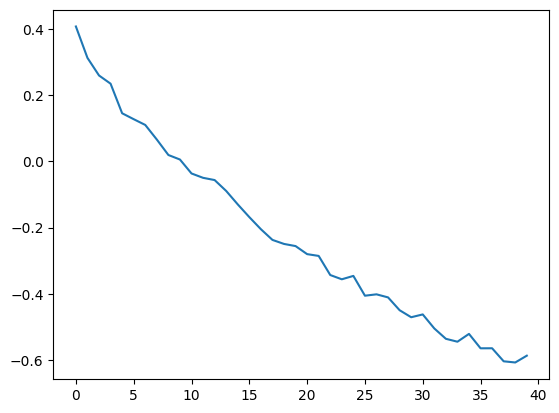

In [29]:
plt.plot(np.log(hist))
plt.savefig('hist-tiny.jpg', bbox_inches='tight')

# Inference

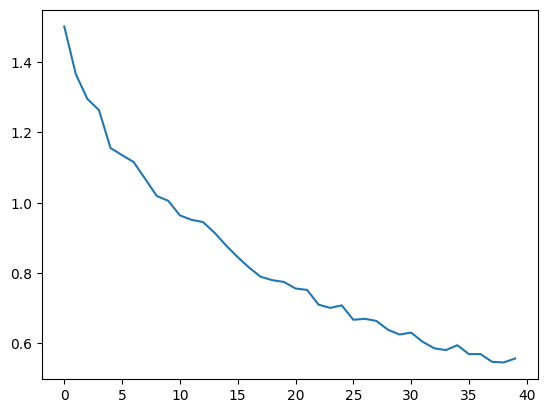

In [29]:
detr.load_state_dict(
    torch.load('ckpts-tiny/model_it040000.new.pt'))

hist = np.load('ckpts-tiny/hist_it040000.npy')

plt.plot(hist)

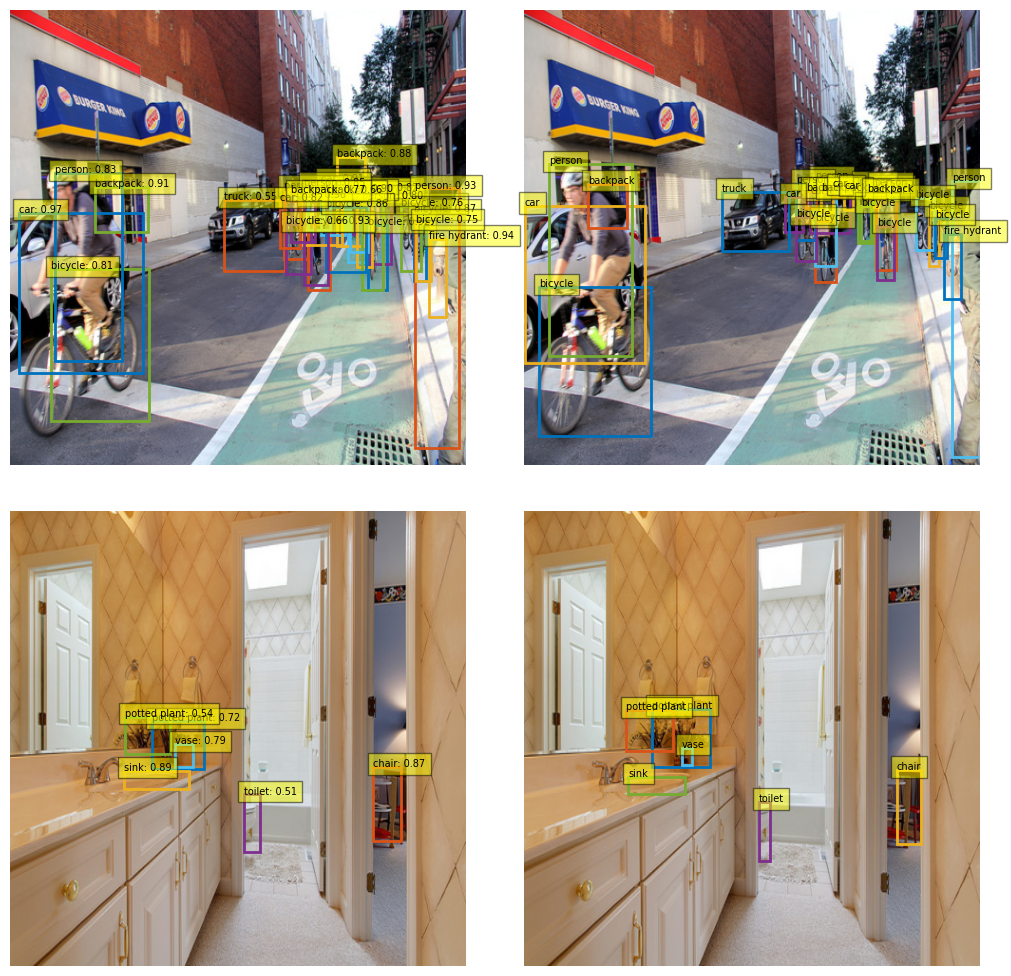

In [32]:
torch.set_grad_enabled(False)
detr.eval()

eval_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True,
    collate_fn=collate_fn)

input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]

# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cuda())['layer_5'].values()
out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()


fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
[a.set_axis_off() for a in axs.ravel()]
    
for ix in range(len(out_bbox)):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]
    
    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    
    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])

In [33]:
# fig.savefig('tiny_predictions_trainsamples.jpg')
# fig.savefig('tiny_predictions_valsamples.jpg')

In [34]:

val_ds = MyCocoDetection(
    'tiny_coco_dataset/tiny_coco/val2017/',
    'tiny_coco_dataset/tiny_coco/annotations/instances_val2017.json',
)

eval_loader = DataLoader(
    val_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Complete COCO dataset

## Training

In [44]:
# wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# wget http://images.cocodataset.org/zips/train2017.zip

# unzip -d. annotations_trainval2017.zip
# unzip -d. train2017.zip

In [35]:
train_ds = MyCocoDetection(
    '/home/rafael/datasets/coco/train2017/',
    '/home/rafael/datasets/coco/annotations/instances_train2017.json',
)
print(f'\nNumber of training samples: {len(train_ds)}')
# Number of training samples: 118287


val_ds = MyCocoDetection(
    '/home/rafael/datasets/coco/val2017/',
    '/home/rafael/datasets/coco/annotations/instances_val2017.json',
)
print(f'\nNumber of val samples: {len(val_ds)}')
# Number of val samples: 5000


loading annotations into memory...
Done (t=11.73s)
creating index...
index created!

Number of training samples: 118287
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!

Number of val samples: 5000


In [36]:
# Ensure saving directory exists
![ -d ckpts2 ] && mkdir ckpts2


detr = DETR(
    d_model=256, n_classes=92, n_tokens=225, 
    n_layers=6, n_heads=8, n_queries=100
)
detr.cuda()

backbone_params = [
    p for n, p in detr.named_parameters() if 'backbone.' in n]

remaining_params = [
    p for n, p in detr.named_parameters() if 'backbone.' not in n]

    
optimizer = AdamW([
    {'params': remaining_params, 'lr': 1e-4},
    {'params': backbone_params, 'lr': 1e-5},
], weight_decay=1e-4)


nparams = sum([p.nelement() for p in detr.parameters()]) / 1e6
print(f'DETR params: {nparams:.1f}M')
# DETR params: 35.2M

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DETR params: 35.2M


In [37]:
# states = torch.load('ckpts-again/model_ep122.pt')
# detr.load_state_dict(states['state'])
# optimizer.load_state_dict(states['opt'])

# hist = np.load('ckpts-again/hist-ep122.npy')
# hist = list(hist)
# print(len(hist))

In [38]:
torch.set_grad_enabled(True)
detr.train()

batch_size = 16
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


nepochs = 2000000
losses = []

hist = []
count = 0

for i_epoch in range(len(hist)+1, nepochs):

    for input_, (tgt_cl, tgt_bbox) in train_loader:
        input_ = input_.cuda()

    
        outs = detr(input_)
        
        loss = torch.Tensor([0]).cuda()
        for name, out in outs.items(): 
            out['bbox'] = out['bbox'].sigmoid()
            
            for o_bbox, t_bbox, o_cl, t_cl in zip(
                out['bbox'], tgt_bbox, out['cl'], tgt_cl):
                
                loss_class, loss_bbox, loss_giou = compute_sample_loss(o_bbox, t_bbox, o_cl, t_cl)
                sample_loss = 1*loss_class + 5*loss_bbox + 2*loss_giou
                # sample_loss = loss_bbox
                loss += sample_loss / batch_size #/ len(outs)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # clip gradient norms
        nn.utils.clip_grad_norm_(detr.parameters(), .1)
        optimizer.step()
        
        losses.append(loss.item())
        
        count += 1
        if count > 10:
            break
        

    if i_epoch % 1 == 0:
        loss_avg = np.mean(losses)
        print_text = f'epoch: {i_epoch},\tloss: {loss_avg:.4f}'
        print(print_text)
        print(f'loss_class: {loss_class.item():.4f}\tloss_bbox: {loss_bbox.item():.4f}\tloss_giou: {loss_giou.item():.4f}\t')
        
        hist.append(loss_avg)
        losses = []
    
    if i_epoch % 1 == 0:
        str_epoch = str(i_epoch)
        str_epoch = '0'*(3-len(str_epoch)) + str_epoch
        
        # torch.save(
        #     {'state':detr.state_dict(),
        #      'opt': optimizer.state_dict()},
        #     f'ckpts/model_ep{str_epoch}.pt')
        
        # np.save(f'ckpts/hist-ep{str_epoch}.npy', hist)

epoch: 1,	loss: 19.0264
loss_class: 0.1362	loss_bbox: 0.3582	loss_giou: 0.9455	
epoch: 2,	loss: 14.8030
loss_class: 1.0056	loss_bbox: 0.0264	loss_giou: 0.9774	
epoch: 3,	loss: 14.1764
loss_class: 0.4649	loss_bbox: 0.0452	loss_giou: 0.9275	
epoch: 4,	loss: 15.0352
loss_class: 0.1994	loss_bbox: 0.1235	loss_giou: 0.8629	
epoch: 5,	loss: 15.3683
loss_class: 1.2370	loss_bbox: 0.0194	loss_giou: 1.0419	
epoch: 6,	loss: 14.9197
loss_class: 0.1900	loss_bbox: 0.1117	loss_giou: 0.7952	
epoch: 7,	loss: 16.2199
loss_class: 0.3905	loss_bbox: 0.0449	loss_giou: 0.7523	
epoch: 8,	loss: 15.7611
loss_class: 1.3313	loss_bbox: 0.0191	loss_giou: 1.0453	
epoch: 9,	loss: 14.6820
loss_class: 1.1650	loss_bbox: 0.0221	loss_giou: 0.9835	


KeyboardInterrupt: 

## Inference

In [46]:
!ls ckpts

hist-ep150.npy	hist-ep190.npy	hist-ep230.npy	model_ep170.pt	model_ep210.pt
hist-ep151.npy	hist-ep191.npy	hist-ep231.npy	model_ep171.pt	model_ep211.pt
hist-ep152.npy	hist-ep192.npy	hist-ep232.npy	model_ep172.pt	model_ep212.pt
hist-ep153.npy	hist-ep193.npy	hist-ep233.npy	model_ep173.pt	model_ep213.pt
hist-ep154.npy	hist-ep194.npy	hist-ep234.npy	model_ep174.pt	model_ep214.pt
hist-ep155.npy	hist-ep195.npy	hist-ep235.npy	model_ep175.pt	model_ep215.pt
hist-ep156.npy	hist-ep196.npy	hist-ep236.npy	model_ep176.pt	model_ep216.pt
hist-ep157.npy	hist-ep197.npy	hist-ep237.npy	model_ep177.pt	model_ep217.pt
hist-ep158.npy	hist-ep198.npy	hist-ep238.npy	model_ep178.pt	model_ep218.pt
hist-ep159.npy	hist-ep199.npy	hist-ep239.npy	model_ep179.pt	model_ep219.pt
hist-ep160.npy	hist-ep200.npy	hist-ep240.npy	model_ep180.pt	model_ep220.pt
hist-ep161.npy	hist-ep201.npy	hist-ep241.npy	model_ep181.pt	model_ep221.pt
hist-ep162.npy	hist-ep202.npy	hist-ep242.npy	model_ep182.pt	model_ep222.pt
hist-ep163.npy	hist-ep203

In [39]:
detr = DETR(
    d_model=256, n_classes=92, n_tokens=225, 
    n_layers=6, n_heads=8, n_queries=100
)
detr.cuda().eval();


# states = torch.load('ckpts/model_ep150.pt')
states = torch.load('ckpts/model_ep249.pt')
detr.load_state_dict(states['state'])
# optimizer.load_state_dict(states['opt'])

hist = np.load('ckpts/hist-ep150.npy')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


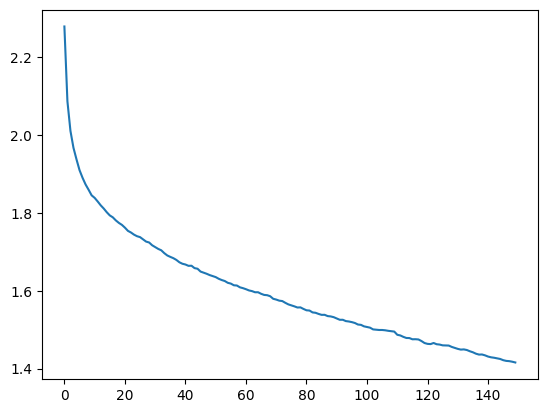

In [40]:
plt.plot(np.log(hist))
# plt.savefig('hist.jpg', bbox_inches='tight')

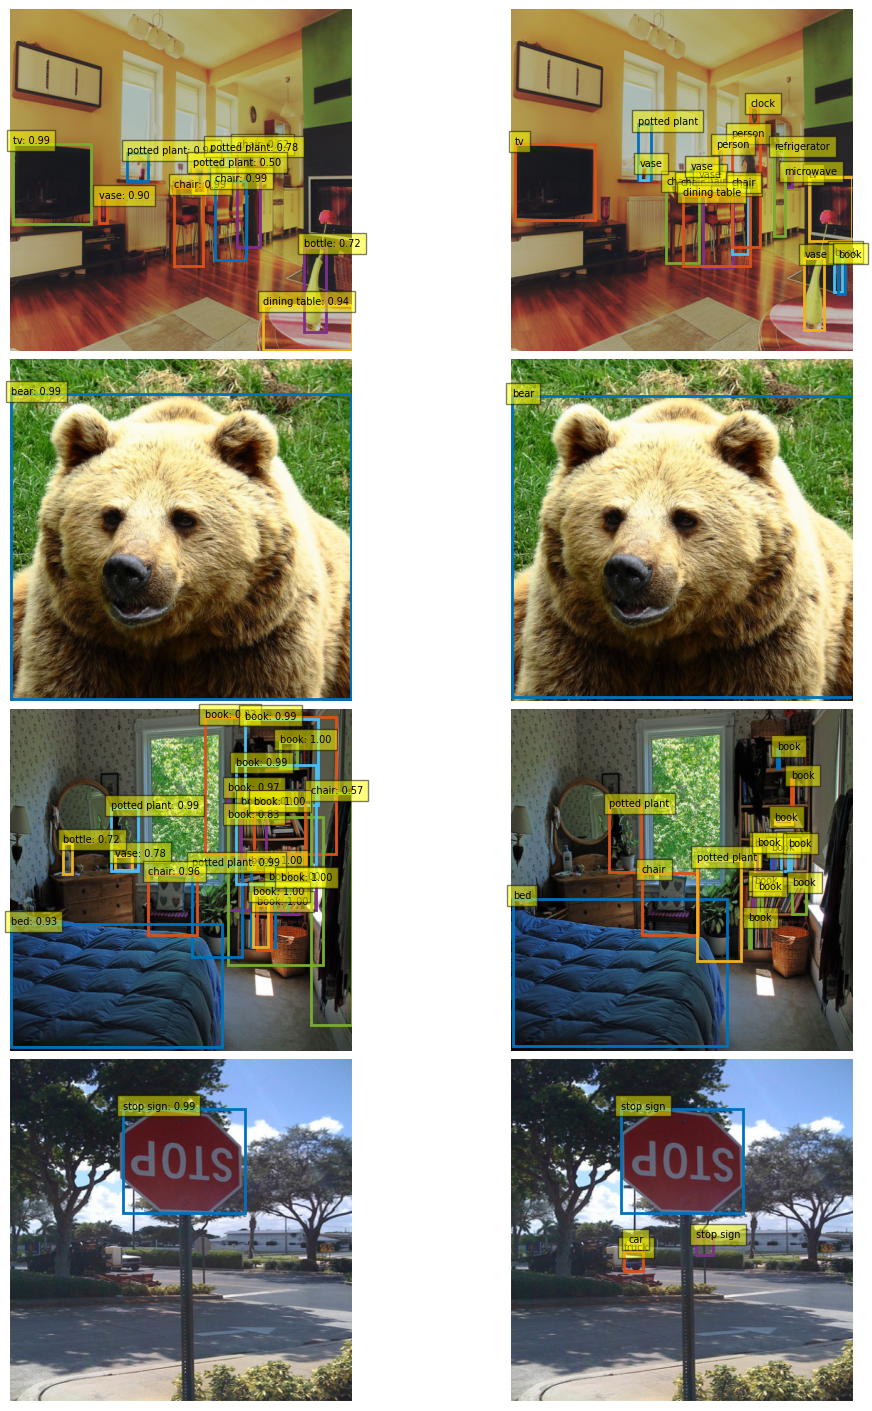

In [41]:
torch.set_grad_enabled(False)
detr.eval()

# torch.manual_seed(0)
# import random
# random.seed(0)
# np.random.seed(0)


eval_loader = DataLoader(
    val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
input_, (tgt_cl, tgt_bbox) = next(iter(eval_loader))[:2]

detr.cpu();
# out_cl, out_bbox = detr(input_.cuda())
out_cl, out_bbox = detr(input_.cpu())['layer_5'].values()

out_bbox = out_bbox.sigmoid().cpu()
out_cl = out_cl.cpu()


fig, axs = plt.subplots(
    len(input_), 2, figsize=(10, 3.5*len(input_)), constrained_layout=True, squeeze=False)
[a.set_axis_off() for a in axs.ravel()]


for ix in range(len(out_bbox)):
    o_cl = out_cl[ix]
    t_cl = tgt_cl[ix]
    o_bbox = out_bbox[ix]
    t_bbox = tgt_bbox[ix]
    
    o_probs = o_cl.softmax(dim=-1)
    o_bbox = ops.box_convert(o_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    t_bbox = ops.box_convert(t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    
    im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

    o_keep = o_probs.argmax(-1) != 91
    # o_keep = np.arange(10)

    axs[ix, 0].imshow(im)
    plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep], ax=axs[ix, 0])
    axs[ix, 1].imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=axs[ix, 1])

In [ ]:
# fig.savefig('tiny_predictions_trainsamples.jpg')
# fig.savefig('predictions_valsamples.jpg')

# Unsplash images

In [ ]:
# %%bash
# [ ! -d unsplash ] && mkdir unsplash/

# for i in {1..4}; do
#     bname=`cat /proc/sys/kernel/random/uuid | sed 's/[-]//g' | head -c 10`
#     wget -q -O unsplash/$bname.jpg https://unsplash.it/1920/1080/?random
# done

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


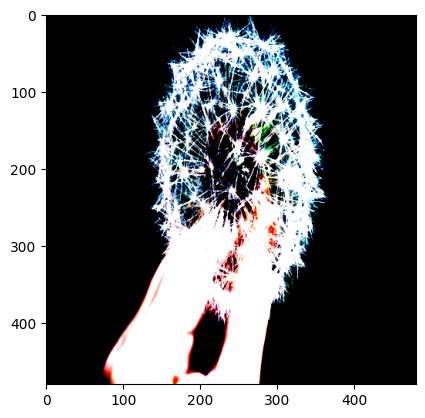

In [39]:
plt.imshow(input_[0].permute(1,2,0).cpu())

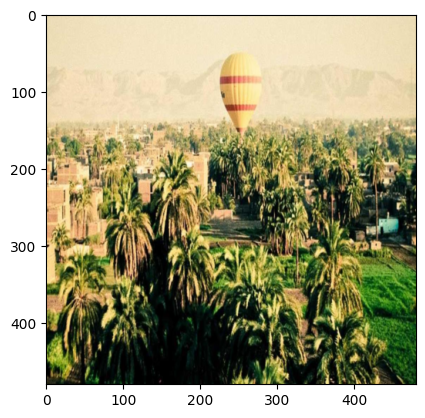

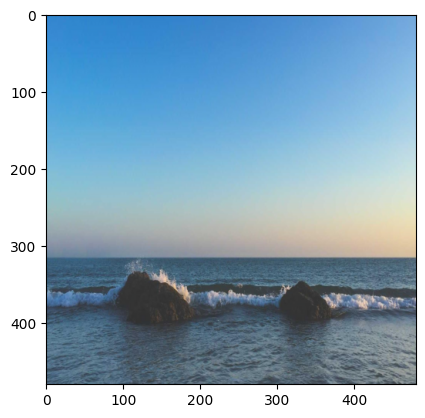

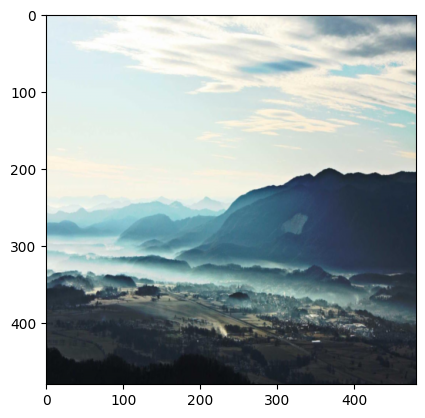

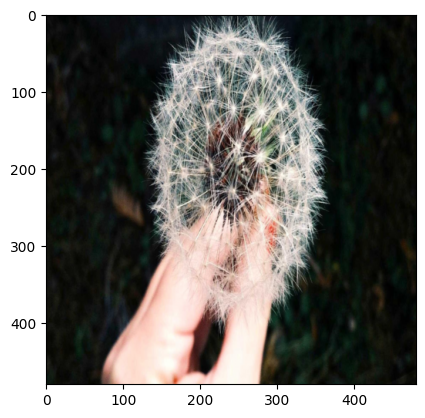

In [53]:
from glob import iglob
import cv2
detr.cuda()

T_detr = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[.485, .456, .406],
        std=[.229, .224, .225]),
    T.Resize((480, 480), antialias=True),
    T.Lambda(lambda x: x[None].cuda())
    ])



for p in iglob('unsplash/*'):
    im = cv2.imread(p)[..., ::-1]
    input_ = T_detr(im.copy())
    
    out_cl, out_bbox = detr(input_)['layer_5'].values()    
    out_bbox = out_bbox.sigmoid()

    for ix in range(len(out_bbox)):
        o_cl = out_cl[ix]
        o_bbox = out_bbox[ix]
    
        o_probs = o_cl.softmax(dim=-1)
        o_bbox = ops.box_convert(o_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')
    
        o_keep = o_probs.argmax(-1) != 91
        # o_keep = torch.arange(len(o_probs))
        
        im = revert_normalization(input_)[ix].permute(1,2,0).cpu().clip(0,1)

        plt.imshow(im)
        plot_im_with_boxes(im, o_bbox[o_keep], o_probs[o_keep])
        plt.show()
        

# Metrics

In [44]:
# !pip install -q datasets evaluate 

Note: you may need to restart the kernel to use updated packages.


In [54]:
from transformers import AutoImageProcessor


class CocoDetection(datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


def collate_fn_eval(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch


image_processor = AutoImageProcessor.from_pretrained('facebook/detr-resnet-50')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [55]:

# test_ds_coco_format = CocoDetection(
#     'tiny_coco_dataset/tiny_coco/val2017/',
#     image_processor,
#     'tiny_coco_dataset/tiny_coco/annotations/instances_val2017.json',
# )

# test_ds_coco_format = CocoDetection(
#     'tiny_coco_dataset/tiny_coco/train2017/',
#     image_processor,
#     'tiny_coco_dataset/tiny_coco/annotations/instances_train2017.json',
# )

test_ds_coco_format = CocoDetection(
    '/home/rafael/datasets/coco/val2017/',
    image_processor,
    '/home/rafael/datasets/coco/annotations/instances_val2017.json',
)


print(f'\nNumber of val samples: {len(test_ds_coco_format)}')

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!

Number of val samples: 5000


In [56]:
import evaluate
from tqdm import tqdm
from types import SimpleNamespace


model = detr.eval()
model.cuda()
# model.cpu()


module = evaluate.load(
    "ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)


val_dataloader = DataLoader(
    test_ds_coco_format, batch_size=4, shuffle=False,
    collate_fn=collate_fn_eval
)


with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        new_pixel_values = []
        for pv in pixel_values:
            nopad = (pv == 0).all(axis=0)
            padh = (nopad*1.).argmax(0).min().item()
            padw = (nopad*1.).argmax(1).min().item()
            padh = padh if padh > 0 else pv.shape[1]
            padw = padw if padw > 0 else pv.shape[2]
            newpv = pv[:, :padh,:padw]
            newpv = T.functional.resize(newpv, (480, 480))
            new_pixel_values.append(newpv)
        
        new_pixel_values = torch.stack(new_pixel_values)

        logits, pred_boxes = model(new_pixel_values.cuda())['layer_5'].values()
        pred_boxes = pred_boxes.sigmoid()

        outputs = SimpleNamespace()
        outputs.logits = logits
        outputs.pred_boxes = pred_boxes        

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = image_processor.post_process(outputs, orig_target_sizes)
        
        module.add(prediction=results, reference=labels)
        del batch

metric = module.compute()
print(metric)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [05:25<00:00,  3.84it/s]


Accumulating evaluation results...
DONE (t=6.98s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [ ]:
# 249 epochs
# IoU metric: bbox
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.229
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.117
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.122
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.229
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.235
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.057
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.252
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.489

In [ ]:
# val
# Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.109
# Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.205
# Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.102
# Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
# Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.104
# Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.206
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.145
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.220
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
# Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.046
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
# Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.482

In [ ]:
# tiny-train
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.177
#  Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.295
#  Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.156
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.072
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.197
#  Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.348
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.242
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.254
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.083
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.251
#  Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.503